In [68]:
import numpy as np
import scipy as sc
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['figure.figsize'] = [6,4]
#plt.rcParams['figure.dpi'] = 300

In [69]:
#constants
T = 0.3
G = 4*np.pi**2

m_sun = 1
m_earth = 3.0*10e-6
m_lunar = 3.69*10e-8

R_earth = 1
R_lunar = 2.57*10e-3

T_earth = 1
T_lunar = 27.3/365.3


In [70]:
#The form of the vector parsed to the Hamiltonian is
#[rxe, rye, rxl, ryl, pxe, pye, pxl, pyl]

def Hamiltonian(state):
    momentum = (state[4]**2 + state[5]**2)/(2*m_earth) + (state[6]**2 + state[7]**2)/(2*m_lunar)
    r1, r2 = state[:2], state[2:4]
    potential = -G*m_sun*m_earth/(np.sqrt(r1.dot(r1)))-G*m_sun*m_lunar/(np.sqrt(r2.dot(r2)))-G*m_lunar*m_earth/(np.sqrt((r1-r2).dot(r1-r2)))

    return momentum + potential


def angular_momentum(state):
    L_earth = state[0]*state[5] - state[1]*state[4]
    L_lunar = state[2]*state[2] - state[3]*state[6]
    return L_earth + L_lunar

In [71]:
#x dot

def x_dot(t, state):
    changed_state = np.zeros(8)
    re = state[:2]
    rl = state[2:4] 
    pe = state[4:6] 
    pl = state[6:]

    changed_state[0] = pe[0]/m_earth
    changed_state[1] = pe[1]/m_earth
    changed_state[2] = pl[0]/m_lunar
    changed_state[3] = pl[1]/m_lunar

    F1 = -G*m_sun*m_earth*re/(np.sqrt(re.dot(re)))**3  - G*m_earth*m_lunar*(re-rl)/(np.sqrt((re-rl).dot(re-rl)))**3 
    F2 = -G*m_sun*m_lunar*rl/(np.sqrt(rl.dot(rl)))**3  - G*m_earth*m_lunar*(rl-re)/(np.sqrt((re-rl).dot(re-rl)))**3 

    #F1 = - G*m_earth*m_lunar*(re-rl)/(np.sqrt((re-rl).dot(re-rl)))**3 
    #F2 = - G*m_earth*m_lunar*(rl-re)/(np.sqrt((re-rl).dot(re-rl)))**3 

    changed_state[4] = F1[0]
    changed_state[5] = F1[1]
    changed_state[6] = F2[0]
    changed_state[7] = F2[1]

    return changed_state



In [72]:

#Initial conditions
initial = np.zeros(8)

initial[0] = R_earth
initial[2] = R_earth+R_lunar
initial[5] = m_earth*R_earth*2*np.pi/T_earth
initial[7] = m_lunar/m_earth*initial[5] + m_lunar*R_lunar*2*np.pi/T_lunar


In [73]:
T_span = (0, T)
t_steps_fine = np.linspace(0, T, round(T/4**(-5)))
t_steps_medium = np.linspace(0, T, round(T/4**(-4)))
t_steps_rough = np.linspace(0, T, round(T/4**(-3)))

result_fine = solve_ivp(x_dot, T_span, initial, t_eval=t_steps_fine, method="RK45")

r1x_coords_fine = result_fine.y[0]
r1y_coords_fine = result_fine.y[1]
r2x_coords_fine = result_fine.y[2]
r2y_coords_fine = result_fine.y[3]

result_medium = solve_ivp(x_dot, T_span, initial, t_eval=t_steps_medium, method="RK45")

r1x_coords_medium = result_medium.y[0]
r1y_coords_medium = result_medium.y[1]
r2x_coords_medium = result_medium.y[2]
r2y_coords_medium = result_medium.y[3]

result_rough = solve_ivp(x_dot, T_span, initial, t_eval=t_steps_rough, method="RK45")

r1x_coords_rough = result_rough.y[0]
r1y_coords_rough = result_rough.y[1]
r2x_coords_rough = result_rough.y[2]
r2y_coords_rough = result_rough.y[3]


last_coords_rough, last_coords_medium, last_coords_fine = result_rough.y[:,-1], result_medium.y[:,-1], result_fine.y[:,-1]

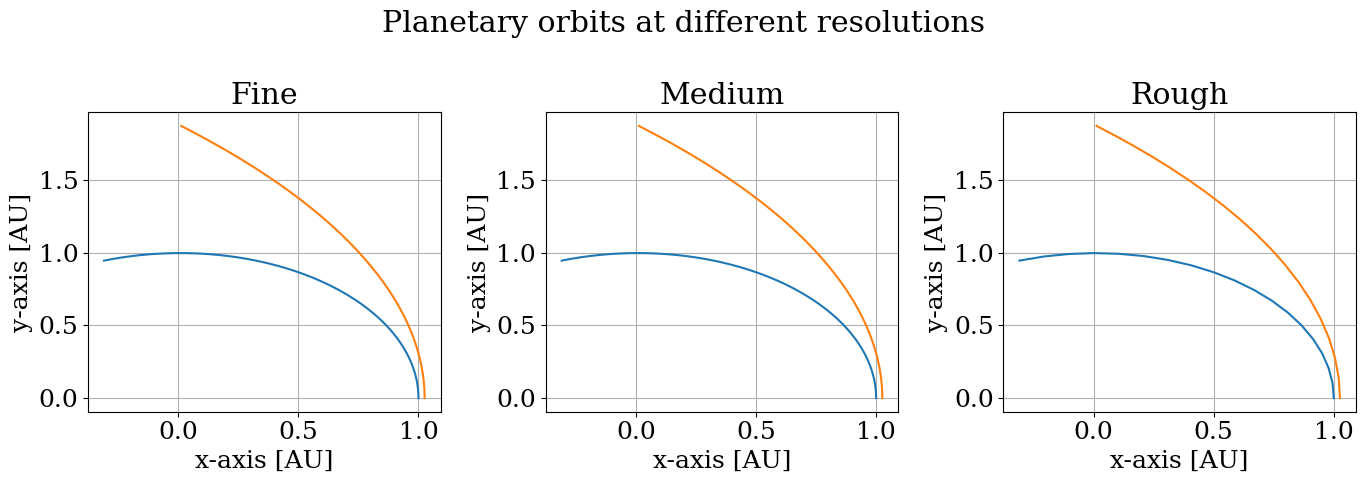

In [74]:
fig, ax = plt.subplots(1,3, figsize = (14,5))

ax[0].plot(r1x_coords_fine, r1y_coords_fine)
ax[0].plot(r2x_coords_fine, r2y_coords_fine)
ax[0].set(title="Fine", xlabel = "x-axis [AU]", ylabel = "y-axis [AU]")

ax[1].plot(r1x_coords_medium, r1y_coords_medium)
ax[1].plot(r2x_coords_medium, r2y_coords_medium)
ax[1].set(title="Medium", xlabel = "x-axis [AU]", ylabel = "y-axis [AU]")

ax[2].plot(r1x_coords_rough, r1y_coords_rough)
ax[2].plot(r2x_coords_rough, r2y_coords_rough)
ax[2].set(title="Rough", xlabel = "x-axis [AU]", ylabel = "y-axis [AU]")

fig.suptitle("Planetary orbits at different resolutions")
fig.tight_layout()

Text(0.5, 1.0, 'Lunar orbit relative to earth')

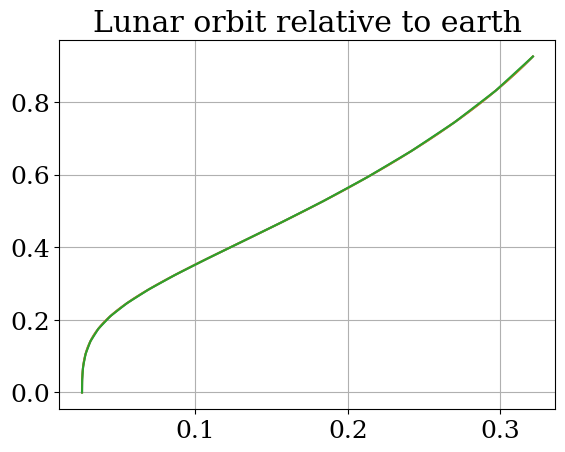

In [75]:
plt.plot(r2x_coords_fine-r1x_coords_fine, r2y_coords_fine-r1y_coords_fine)
plt.plot(r2x_coords_medium-r1x_coords_medium, r2y_coords_medium-r1y_coords_medium)
plt.plot(r2x_coords_rough-r1x_coords_rough, r2y_coords_rough-r1y_coords_rough)

plt.title("Lunar orbit relative to earth")


In [76]:
for i in range(len(np.transpose(result_rough.y))):
    energy_rough = np.zeros(len(np.transpose(result_rough.y)))
    energy_rough[i] = Hamiltonian(np.transpose(result_rough.y)[i])

for i in range(len(np.transpose(result_medium.y))):
    energy_medium = np.zeros(len(np.transpose(result_medium.y)))
    energy_medium[i] = Hamiltonian(np.transpose(result_medium.y)[i])

for i in range(len(np.transpose(result_fine.y))):
    energy_fine = np.zeros(len(np.transpose(result_fine.y)))
    energy_fine[i] = Hamiltonian(np.transpose(result_fine.y)[i])


print(len(np.transpose(result_rough.y)), len(np.transpose(result_medium.y)), len(np.transpose(result_fine.y)))

19 77 307


In [77]:
energy_fine[300:], energy_medium[70:], energy_rough[12:] 

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.00059716]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.00059716]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.00059716]))

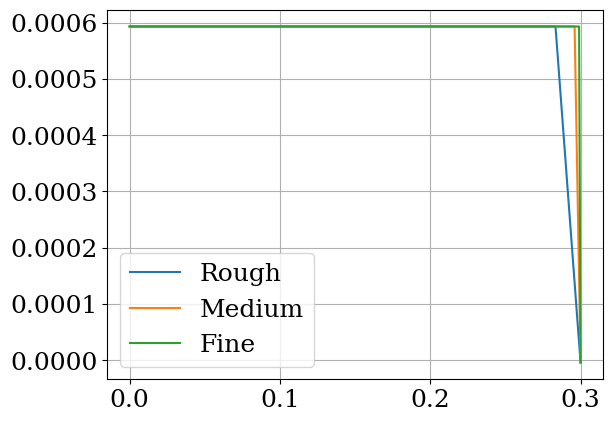

In [78]:
H0 = Hamiltonian(initial)

plt.plot(result_rough.t, energy_rough-H0, label = "Rough")
plt.plot(result_medium.t, energy_medium-H0, label = "Medium")
plt.plot(result_fine.t, energy_fine-H0, label = "Fine")

plt.legend()

In [79]:
Hamiltonian(initial)

-0.0005932410118325644

# Verlet

In [80]:
def force(pos_vector):
    re = pos_vector[:2]
    rl = pos_vector[2:]

    x1 = -G*m_sun*m_earth*re/(np.sqrt(re.dot(re)))**3  - G*m_earth*m_lunar*(re-rl)/(np.sqrt((re-rl).dot(re-rl)))**3
    x2 = -G*m_sun*m_earth*re/(np.sqrt(re.dot(re)))**3  - G*m_earth*m_lunar*(re-rl)/(np.sqrt((re-rl).dot(re-rl)))**3 

    new_pos_vector = np.zeros(4)
    new_pos_vector[:2] = x1
    new_pos_vector[2:] = x2

    return new_pos_vector

In [81]:
def Verlet_step(x, p, F, delta_t):
    #First step
    p_prime = p + F(x)*delta_t/2
    #Second step
    x_1e = x[:2] + 1/m_earth * p_prime[:2]*delta_t
    x_1l = x[2:] + 1/m_lunar * p_prime[2:]*delta_t
    x_1 = np.zeros(4)
    x_1[:2], x_1[2:] = x_1e, x_1l

    #Third step
    F_1 = F(x_1)
    #Fourth step
    p_1 = F_1 * delta_t /2

    return (x_1, p_1 ,F_1)

In [82]:
delta_t = 4**(-5)
T = 0.3

N = round(T/delta_t)


x_vector = initial[:4]
p_vector = initial[4:]
F_vector = force(x_vector)

x_array = np.zeros((N, 4))
p_array = np.zeros((N, 4))


for i in range(N): #Use enumerate

    temp_x, temp_p, temp_F = Verlet_step(x_vector, p_vector, force, delta_t=delta_t)

    x_vector, p_vector, F_vector = temp_x, temp_p, temp_F

    x_array[i] = x_vector
    p_array[i] = p_vector




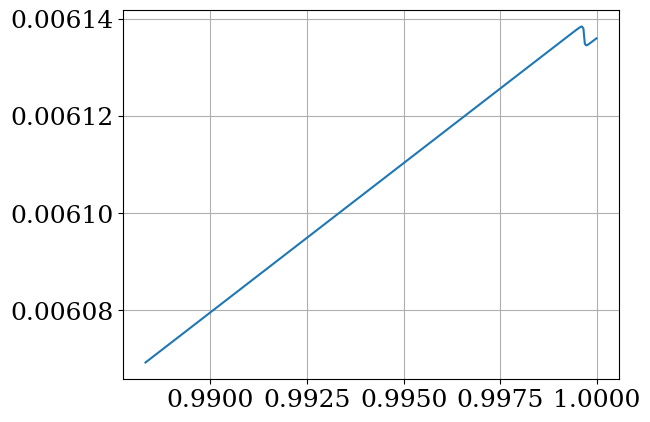

In [83]:
earth_x = np.transpose(x_array)[0]
earth_y = np.transpose(x_array)[1]

lunar_x = np.transpose(x_array)[2]
lunar_y = np.transpose(x_array)[3]

plt.plot(earth_x, earth_y)

## Backwards in time

In [84]:
T_back = (T, 0)
t_steps_rough_back = np.flip(t_steps_rough)
t_steps_medium_back = np.flip(t_steps_medium)
t_steps_fine_back = np.flip(t_steps_fine)

last_coords_rough[4:] = -last_coords_rough[4:]
last_coords_medium[4:] = -last_coords_medium[4:]
last_coords_fine[4:] = -last_coords_fine[4:]

backwards_result_rough = solve_ivp(x_dot, T_span, last_coords_rough, t_eval=t_steps_rough, method="RK45")
backwards_result_medium = solve_ivp(x_dot, T_span, last_coords_medium, t_eval=t_steps_medium, method="RK45")
backwards_result_fine = solve_ivp(x_dot, T_span, last_coords_fine, t_eval=t_steps_fine, method="RK45")

In [85]:
r1x_coords_rough_back = backwards_result_rough.y[0]
r1y_coords_rough_back = backwards_result_rough.y[1]
r2x_coords_rough_back = backwards_result_rough.y[2]
r2y_coords_rough_back = backwards_result_rough.y[3]

r1x_coords_medium_back = backwards_result_medium.y[0]
r1y_coords_medium_back = backwards_result_medium.y[1]
r2x_coords_medium_back = backwards_result_medium.y[2]
r2y_coords_medium_back = backwards_result_medium.y[3]

r1x_coords_fine_back = backwards_result_fine.y[0]
r1y_coords_fine_back = backwards_result_fine.y[1]
r2x_coords_fine_back = backwards_result_fine.y[2]
r2y_coords_fine_back = backwards_result_fine.y[3]

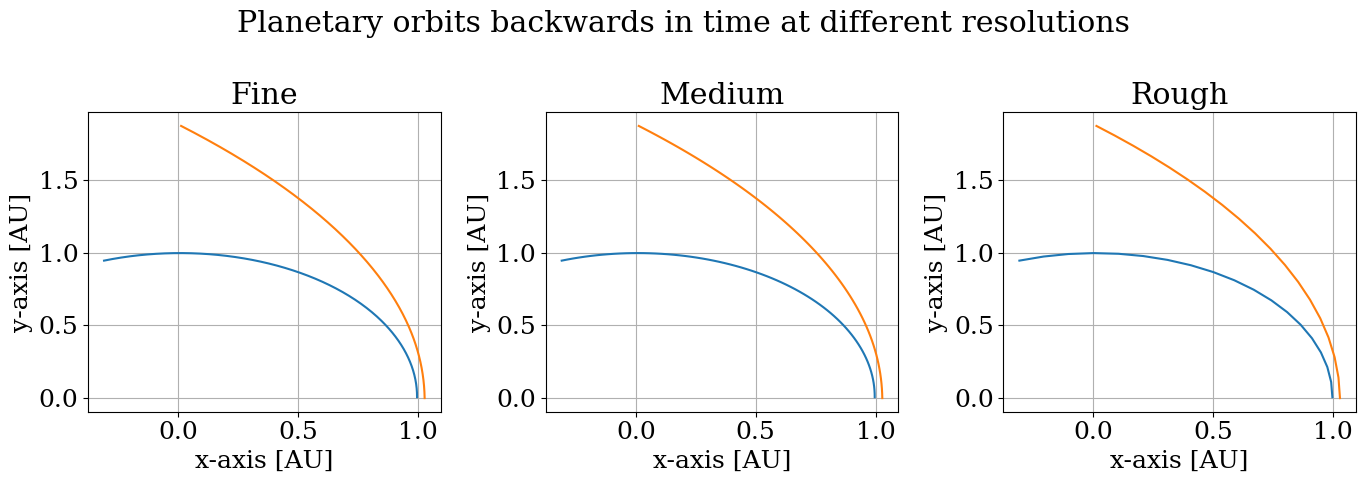

In [86]:
fig, ax = plt.subplots(1,3, figsize = (14,5))

ax[0].plot(r1x_coords_fine_back, r1y_coords_fine_back)
ax[0].plot(r2x_coords_fine_back, r2y_coords_fine_back)
ax[0].set(title="Fine", xlabel = "x-axis [AU]", ylabel = "y-axis [AU]")

ax[1].plot(r1x_coords_medium_back, r1y_coords_medium_back)
ax[1].plot(r2x_coords_medium_back, r2y_coords_medium_back)
ax[1].set(title="Medium", xlabel = "x-axis [AU]", ylabel = "y-axis [AU]")

ax[2].plot(r1x_coords_rough_back, r1y_coords_rough_back)
ax[2].plot(r2x_coords_rough_back, r2y_coords_rough_back)
ax[2].set(title="Rough", xlabel = "x-axis [AU]", ylabel = "y-axis [AU]")

fig.suptitle("Planetary orbits backwards in time at different resolutions")
fig.tight_layout()

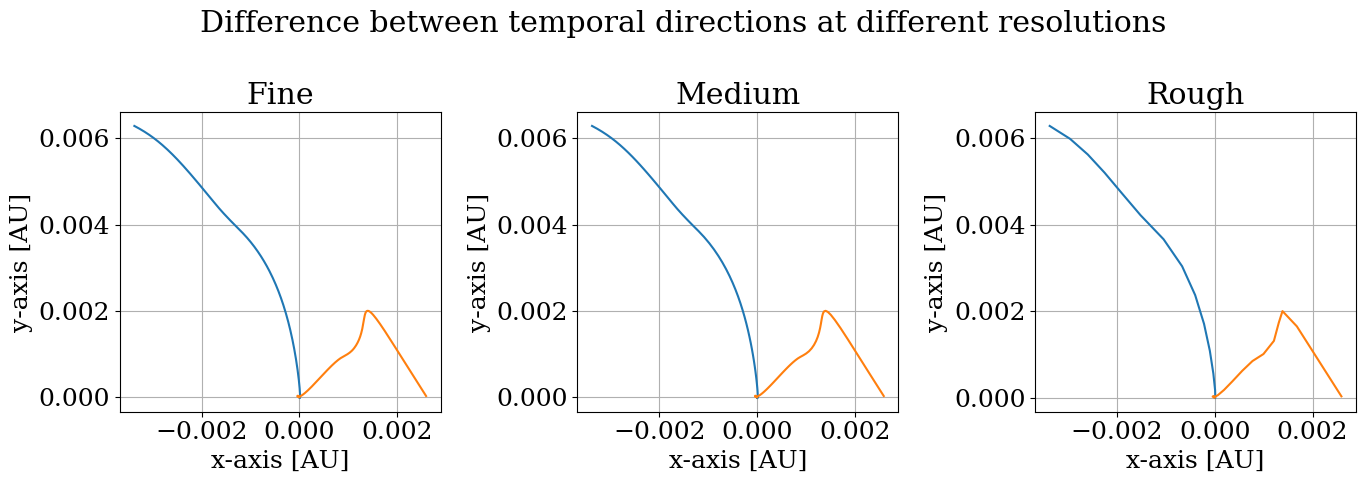

In [87]:
fig, ax = plt.subplots(1,3, figsize = (14,5))

ax[0].plot(np.flip(r1x_coords_fine_back) - r1x_coords_fine, np.flip(r1y_coords_fine_back) - r1y_coords_fine)
ax[0].plot(np.flip(r2x_coords_fine_back)- r2x_coords_fine, np.flip(r2y_coords_fine_back) - r2y_coords_fine)
ax[0].set(title="Fine", xlabel = "x-axis [AU]", ylabel = "y-axis [AU]")

ax[1].plot(np.flip(r1x_coords_medium_back) - r1x_coords_medium, np.flip(r1y_coords_medium_back) - r1y_coords_medium)
ax[1].plot(np.flip(r2x_coords_medium_back) - r2x_coords_medium, np.flip(r2y_coords_medium_back) - r2y_coords_medium)
ax[1].set(title="Medium", xlabel = "x-axis [AU]", ylabel = "y-axis [AU]")

ax[2].plot(np.flip(r1x_coords_rough_back) - r1x_coords_rough, np.flip(r1y_coords_rough_back) - r1y_coords_rough)
ax[2].plot(np.flip(r2x_coords_rough_back) - r2x_coords_rough, np.flip(r2y_coords_rough_back) - r2y_coords_rough)
ax[2].set(title="Rough", xlabel = "x-axis [AU]", ylabel = "y-axis [AU]")

fig.suptitle("Difference between temporal directions at different resolutions")
fig.tight_layout()

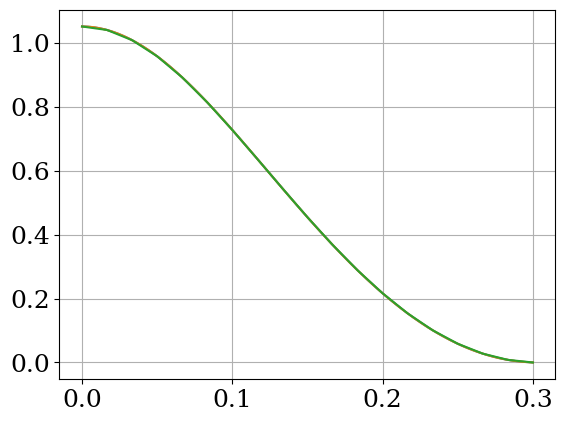

In [88]:
plt.plot(result_fine.t, angular_momentum(result_fine.y))
plt.plot(result_medium.t, angular_momentum(result_medium.y))
plt.plot(result_rough.t, angular_momentum(result_rough.y))